**IMPORTING REQUIRED LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib


**LOADING THE DATASET**

In [ ]:
dataset_path = "/content/drive/MyDrive/tea disease dataset/tea sickness dataset"
dataset_dir = pathlib.Path(dataset_path)

In [ ]:
class_names = []
for x in os.walk(dataset_path):
    sub_dir = x[0]
    sub_dir_list = str(sub_dir).split('/')
    if len(sub_dir_list) > 4:
        x_class = (sub_dir_list[-1])
        class_names.append(x_class)

print(class_names)

['tea sickness dataset', 'algal leaf', 'healthy', 'Anthracnose', 'red leaf spot', 'gray light', 'brown blight', 'bird eye spot', 'white spot']


In [ ]:
for class_i in class_names:
    image_count = len(list(dataset_dir.glob(f'{class_i}/*.jpg')))
    print(f"Images in class {class_i}:",image_count)


Images in class tea sickness dataset: 0
Images in class algal leaf: 113
Images in class healthy: 74
Images in class Anthracnose: 100
Images in class red leaf spot: 143
Images in class gray light: 100
Images in class brown blight: 113
Images in class bird eye spot: 100
Images in class white spot: 142


**SETTING THE PARAMETERS FOR THE TRAIN AND VALIDATION SET**

In [ ]:
train_batch = 128
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
val_split = 0.2

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,validation_split=val_split,subset="training",
seed=123,image_size=(img_height, img_width),batch_size=train_batch)


Found 885 files belonging to 8 classes.
Using 708 files for training.


In [ ]:
# Load data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,validation_split=val_split,subset="validation",
seed=123,image_size=(img_height, img_width),batch_size=val_batch )


Found 885 files belonging to 8 classes.
Using 177 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

num_classes=len(class_names)

['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


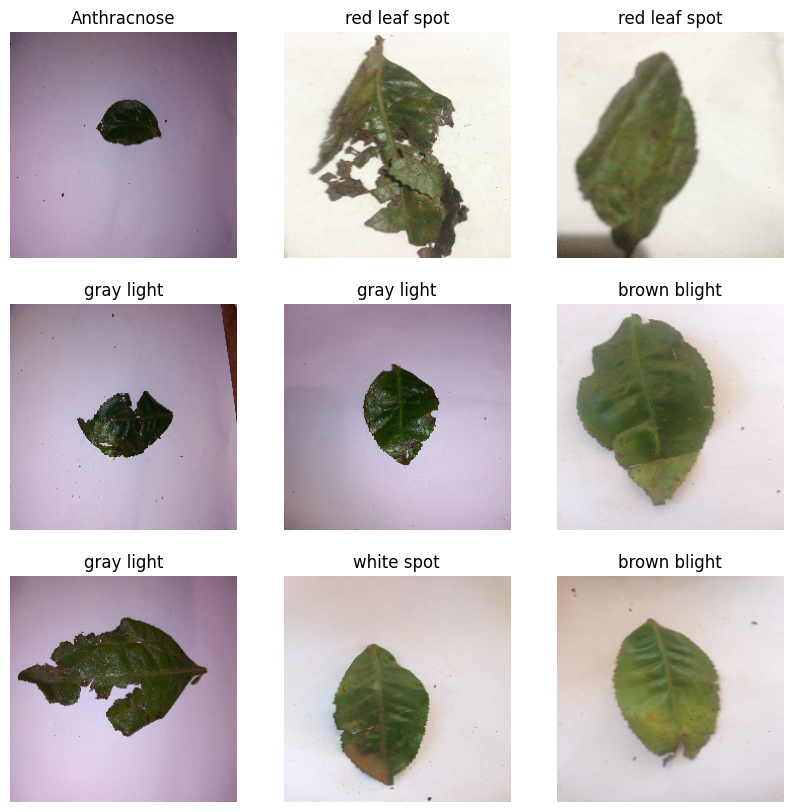

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**BUILDING THE MODEL**

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),])

In [ ]:
# Model architecture
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(num_classes)
])

In [ ]:
# compile model
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                  

In [ ]:
epochs=320
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs,verbose=0)

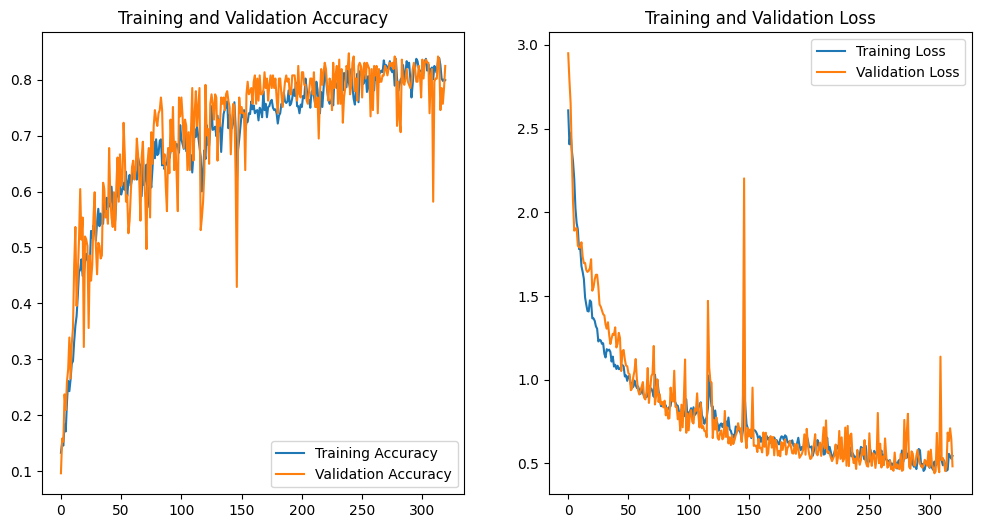

In [ ]:
# Check training result
epochs=320
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predictions:
 [3 7 0 7 2 3 2 1 1 4 4 3 7 6 0 1 0 3 3 4 3 0 6 3 7 4 7 1 4 4 3 5 3 0 7 4 3
 7 0 4 7 7 6 2 0 4 6 3 1 3 6 2 3 4 4 3 7 1 5 0 6 4 2 4 1 6 4 6 3 5 3 3 3 2
 2 3 1 3 2 2 2 6 6 0 0 1 1 4 7 0 2 4 5 3 2 6 4 7 7 3 2 6 0 7 4 1 3 3 5 6 5
 5 7 6 1 3 2 3 7 0 3 4 3 4 4 7 3 4]
Labels:
 [3 7 2 7 0 7 2 1 1 4 0 7 7 6 0 1 2 3 3 4 3 0 6 3 7 4 1 1 0 4 7 5 3 0 6 4 3
 7 4 4 7 7 6 2 0 4 6 3 1 3 6 2 7 4 4 3 7 1 5 0 6 4 0 4 1 6 4 6 3 5 3 7 3 2
 2 7 1 3 2 0 4 6 6 0 0 1 1 4 7 0 0 4 5 3 2 6 4 7 7 3 2 6 0 7 4 1 3 3 5 6 5
 5 7 6 1 3 2 3 7 0 3 4 3 0 4 7 3 0]

              precision    recall  f1-score   support

           0       0.77      0.56      0.65        18
           1       1.00      0.92      0.96        13
           2       0.64      0.82      0.72        11
           3       0.79      1.00      0.88        23
           4       0.82      0.90      0.86        20
           5       1.00      1.00      1.00         7
           6       1.00      0.93      0.97        15
           7       0.

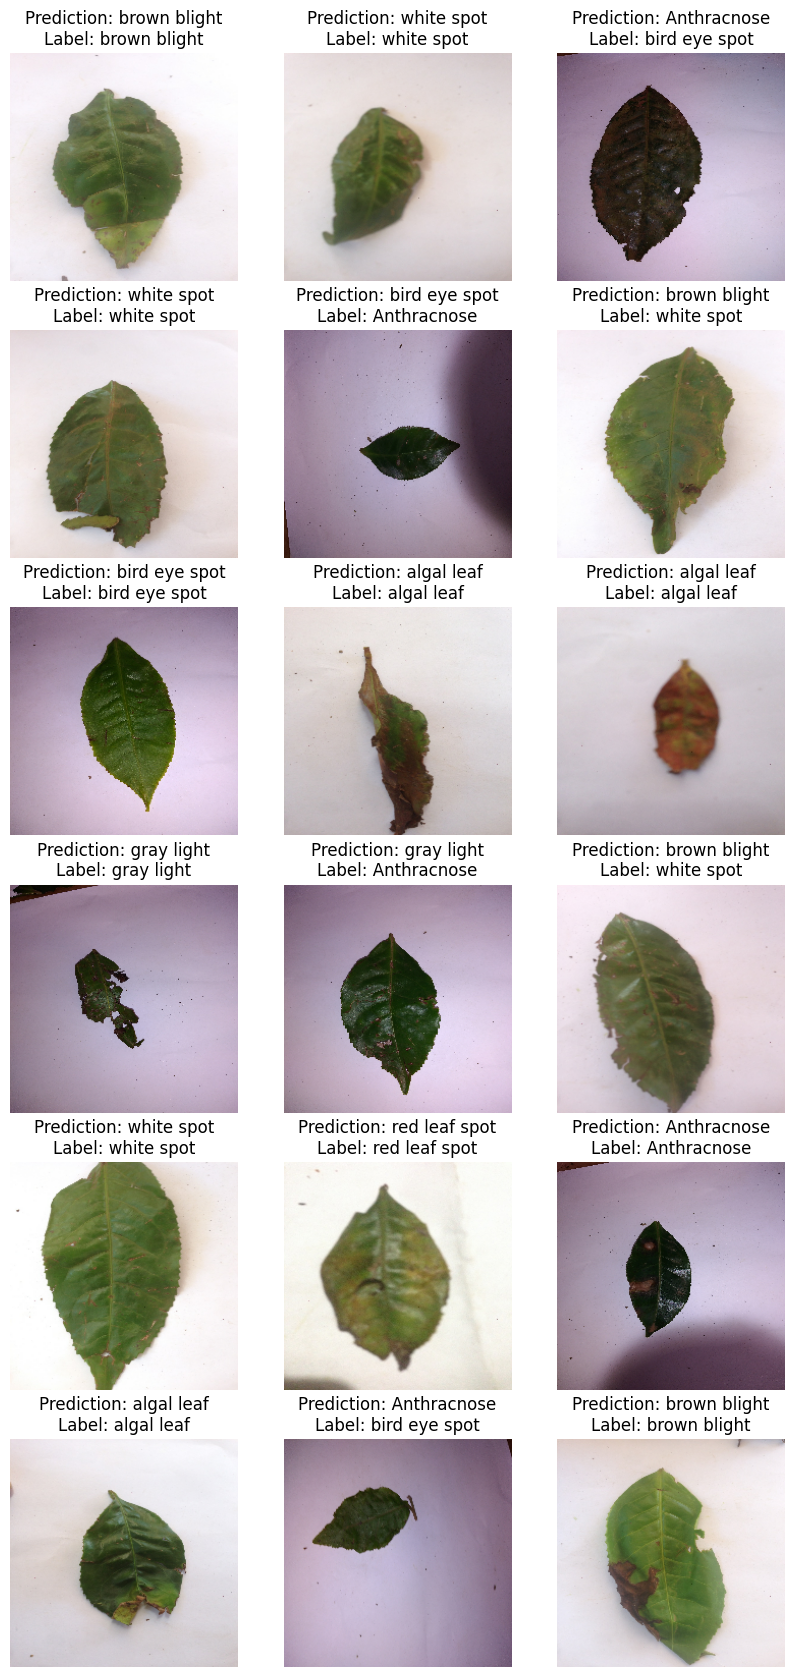

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv("history.csv")
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
315,0.462144,0.826271,0.684201,0.745763
316,0.557518,0.802260,0.634314,0.785311
317,0.542956,0.798023,0.709916,0.757062
318,0.528405,0.800847,0.645782,0.785311
319,0.544812,0.799435,0.482700,0.824859
